# 15. Model extensions

## Numerical experiments - Week 18/2025

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

Despite the moderate success of the analytical model in explaining the phase transition of the spore inoculum from a germinated to an ungerminated state when the critical threshold of $10^5$ spores/mL is crossed, a few issues remain to be addressed:

- It is known that spore cultures reach an asymptotic limit of their germination fraction, but the new analytical model has not yet been shown to represent that.
- The estimated effective permeation constant $P_{\textrm{eff}}$ is too low for any realistic barrier which does not interact with the inhibitor.
- The model cannot represent density-driven inhibition and exogenously driven exhibition in parallel.

The following model extensions are an attempt to address these issues.

## Prerequisite libraries

In [1]:
using PyPlot
using BlackBoxOptim
using Revise

Revise.includet("./conversions.jl")
Revise.includet("./diffusion.jl")
Revise.includet("./setup.jl")
Revise.includet("./plotting.jl")
Revise.includet("./analysis.jl")
Revise.includet("./utils.jl")
using .Conversions
using .Diffusion
using .Setup
using .Plotting
using .Analysis
using .Utils

## 1. Replicating Dantigny-like behaviour

### 1.1. Implementation of the Dantigny model

The model developed by Dantigny et al. [1] describes the germination percentage of a fungal culture through the formula

$$
\begin{equation}
p=p_{\textrm{max}}\left[1-\frac{1}{1+\left(\frac{t}{\tau_g}\right)^\nu}\right].
\end{equation}
$$

In it, $t$ is the time of evaluation of the probability, $p_{\textrm{max}}$ is a saturation limit of the germination fraction, $\tau_g$ is a characteristic germination time denoting the inflection point where $p=p_{\textrm{max}}/2$ and $\nu$ is a design parameter representing the heterogeneity of the culture.

It has been shown that the value of $p$ in this model saturates to $p_{\textrm{max}}$ in the long-time limits and has an asymmetrical sigmoid shape for $\nu>1$. As an illustration, some inferred parameters from Ijadpanahsaravi et al. [2] which describe the germination rate of _A. niger_ conidia in an alanine-rich environment, at a density of $1.333\times 10^5$ spores/mL, are $p_{\textrm{max}}=84.14$, $\tau_g=5.77$ and $\nu=3.36$. The code below illustrates the evolution of the germination percentage over the course of 50 hours.

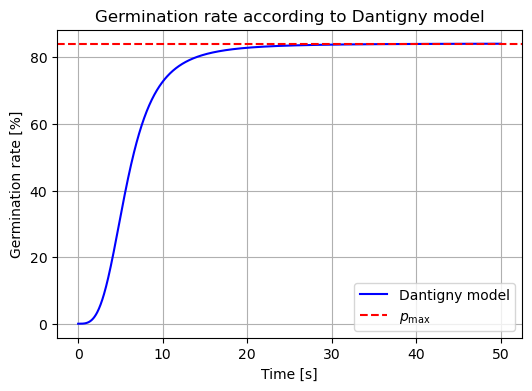

In [12]:
function dantigny(t, p_max, τ, ν)
    """
    Dantigny model for the germination of a fungal culture.
    inputs:
        t: time (in hours)
        p_max: maximum germination rate
        τ: time constant (in hours)
        ν: design parameter (dimensionless)
    outputs:
        p: germination rate (dimensionless)
    """
    p = p_max * (1 - 1 / (1 + (t / τ)^ν))
    return p
end

t_max = 50 # hours
p_max = 84.14
τ = 5.77
ν = 3.36

times = LinRange(0, t_max, 1000)
ps = dantigny.(times, p_max, τ, ν)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(times, ps, label="Dantigny model", color="blue")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Germination rate [%]")
ax.grid()
ax.set_title("Germination rate according to Dantigny model")

ax.axhline(y=p_max, color="red", linestyle="--", label=L"p_{\text{max}}")
ax.legend()

gcf()

### 1.2. Time-dependent germination probability

Next, the time-dependent germination probability is simulated using the volume-based analytical model. Knowing that the germination response saturates at around 24 hours, the parameters of the model can be fitted again for the time-dependent comparison.

In [2]:
df_germination_rebuilt = parse_ijadpanahsaravi_data()

Row,CarbonSource,Density,Pmax,Pmax_CI_Lower,Pmax_CI_Upper,tau,tau_CI_Lower,tau_CI_Upper,N,M
,String3,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64
1,Ala,33333.3,95.98,92.44,99.51,6.93,6.59,7.26,373,10
2,Ala,66666.7,90.81,86.43,95.18,5.28,4.84,5.72,979,37
3,Ala,1.33333e5,84.14,78.58,89.69,5.77,5.17,6.37,1112,66
4,Ala,2.66667e5,71.91,61.67,82.14,6.31,5.06,7.57,1301,89
5,Arg,33333.3,25.06,-0.83,50.96,15.0,1.47,28.53,626,94
6,Arg,66666.7,16.61,5.63,27.6,15.0,7.02,22.98,1026,19
7,Arg,1.33333e5,13.69,4.32,23.05,15.0,-0.44,30.44,1372,14
8,Arg,2.66667e5,11.25,-1.93,24.43,15.0,-12.95,42.95,1408,105
9,Pro,33333.3,94.95,91.22,98.69,4.55,4.19,4.91,526,7


5.9918304202075915e-6
Carbon source: Ala
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 6722 evals, 6627 steps, improv/step: 0.219 (last = 0.2188), fitness=0.001245841
1.00 secs, 13170 evals, 13078 steps, improv/step: 0.215 (last = 0.2119), fitness=0.001087512
1.51 secs, 18538 evals, 18451 steps, improv/step: 0.209 (last = 0.1937), fitness=0.001087466
2.01 secs, 23378 evals, 23294 steps, improv/step: 0.189 (last = 0.1115), fitness=0.001087466

Optimization stopped after 31108 steps and 2.50 seconds
Termination reason: Too many steps (101) without any function evaluations (probably search has converged)
Steps per second = 12448.18
Function evals per second = 11490.60
Improvements/step = 0.04602
Total function evaluations = 28715


Best candidate found: [3.87831, 3.77978e-5, 1.81853e-5]

Fitness: 0.001087466

Optimized par

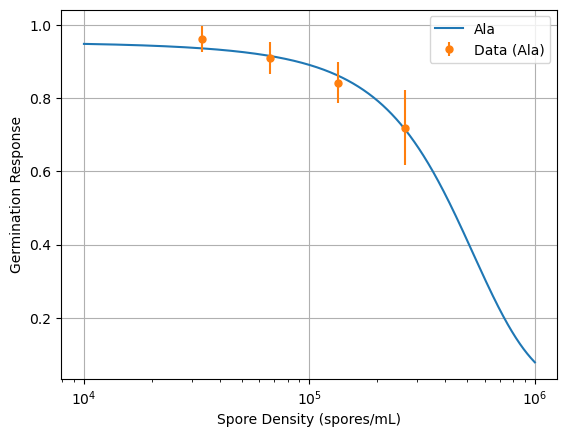

In [ ]:
# Constants
μ_ξ = 2.65
σ_ξ = 0.3
t_max = 24

# Bounds for the parameters
lower_bounds = [2, 1e-10, 1e-12]
upper_bounds = [5, 1.0, 0.1]
bounds = [(lb, ub) for (lb, ub) in zip(lower_bounds, upper_bounds)]

fig, ax = plt.subplots()

carbon_srcs = unique(df_germination_rebuilt[!, :CarbonSource])
sample_density_exp = LinRange(4, 6, 1000)

src = "Ala"

# Gather data
println("Carbon source: ", src)
df_src = filter(row -> row[:CarbonSource] == src, df_germination_rebuilt)
spore_densities = df_src[!, :Density]
spore_density_exponents = log10.(spore_densities)
germination_responses = df_src[!, :Pmax] * 0.01

# confidence_intervals
err_lo = df_src[!, :Pmax]-df_src[!, :Pmax_CI_Lower]
err_lo[err_lo .< 0] .= 0
err_hi = df_src[!, :Pmax_CI_Upper]-df_src[!, :Pmax]
err_lo = err_lo * 0.01
err_hi = err_hi * 0.01

# Define a scalar objective: sum of squared errors
function obj(params)
    ŷ = germination_response_simple.(10 .^ spore_density_exponents, 10 .^ (-params[1]), params[2], params[3], μ_ξ, σ_ξ, t_max * 3600)
    return sum(abs2, ŷ .- germination_responses)
end

# Fit model
res = bboptimize(params -> obj(params);
                SearchRange = bounds,
                NumDimensions = 3,
                MaxSteps = 100000)
p_opt = best_candidate(res)

Pₛ_fit = 10 .^ (-p_opt[1])
μ_γ_fit = p_opt[2]
σ_γ_fit = p_opt[3]

println("Optimized parameters:")
println("Pₛ: ", Pₛ_fit)
println("μ_γ: ", μ_γ_fit)
println("σ_γ: ", σ_γ_fit)
println("")

fit_responses = germination_response_simple.(10 .^ sample_density_exp, Pₛ_fit, μ_γ_fit, σ_γ_fit, μ_ξ, σ_ξ, t_max * 3600)
ax.plot(10 .^ sample_density_exp, fit_responses, label=src)
ax.errorbar(spore_densities, germination_responses, yerr=[err_lo, err_hi], fmt="o", markersize=5, label="Data ($(src))")

ax.set_xscale("log")
ax.set_xlabel("Spore Density (spores/mL)")
ax.set_ylabel("Germination Response")
ax.grid()
ax.legend()

gcf()

In [14]:
ρ = 1.33333e5 # spores/mL

times = LinRange(0, t_max * 2, 1000) # hours

p_evolution = germination_response_simple.(ρ, Pₛ_fit, μ_γ_fit, σ_γ_fit, μ_ξ, σ_ξ, times .* 3600) .* 100 # Convert to percentage

1000-element Vector{Float64}:
  0.0
  1.0985270665090286e-17
  2.4363903125233555e-17
  4.065088540021347e-17
  6.047054348251181e-17
  8.457942459154397e-17
  1.1389389682129073e-16
  1.4952342148626472e-16
  1.9281064501352566e-16
  2.453796850335962e-16
  ⋮
 92.72379730617244
 92.72379983962915
 92.72380232035044
 92.72380474944079
 92.72380712798135
 92.72380945703047
 92.72381173762426
 92.72381397077696
 92.7238161574815

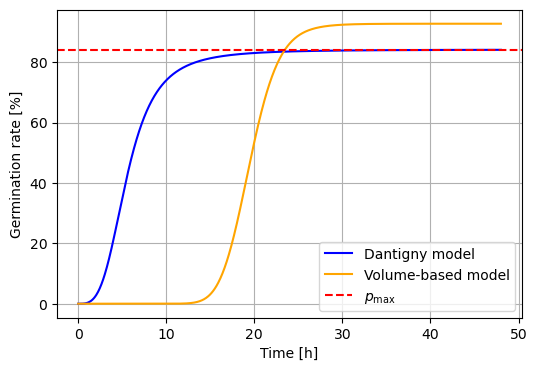

In [15]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(times, ps, label="Dantigny model", color="blue")
ax.plot(times, p_evolution, label="Volume-based model", color="orange")
ax.set_xlabel("Time [h]")
ax.set_ylabel("Germination rate [%]")
ax.grid()
# ax.set_title("Germination rate according to Dantigny model")

ax.axhline(y=p_max, color="red", linestyle="--", label=L"p_{\text{max}}")
ax.legend()

gcf()

Despite the common sigmoidal shape of the resulting evolutions, two major differences can be observed in the two models. First, the Dantigny saturates to levels lower than a full germination, while the volume-based model always saturates to 100%. Second, the peak of germination (concurrent with the steepest slope of the curve) may occur at a different time in the volume-based model, since the models rely on the attainment of a germination level at a specific time. This is also a consequence of the fact that the targeted germination level is not an asymptotic limit, but a momentary snapshot.

### 1.3. Fitting the equilibrium probability

Since the germination responses in this case are expressed as asymptotical limits of the Dantigny model [5], the volume-based model needs to be taken in its long-time equilibrium form,

$$
\begin{equation}
c_{\textrm{eq}}=\phi c_0.
\end{equation}
$$

The germination condition thus becomes

$$
\begin{equation}
c_{\textrm{eq}} < c_T,
\end{equation}
$$

or, using the previously defined random variables,

$$
\begin{equation}
\phi{(\xi, \rho_s)} c_0 < \gamma c_0,
\end{equation}
$$

$$
\begin{equation}
\phi{(\xi, \rho_s)} < \gamma.
\end{equation}
$$

The probability for germination under a certain spore density is then expressed as

$$
\begin{equation}
p{(\rho_s)}=P{(\phi < \gamma\ |\ \xi)}=\int_0^\infty{P{(\phi < \gamma\ |\ \xi, \rho_s)}\ f_\xi\ d{\xi}}.
\end{equation}
$$

Following the Gaussian assumption about $\xi$,

$$
\begin{equation}
p{(\rho_s)}=\int_0^\infty{\left[1-\Phi{\left(\frac{\phi{(\xi)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ \frac{1}{\sqrt{2\pi}\sigma_\xi}\exp{\left(-\frac{(\xi-\mu_\xi)^2}{2\sigma_\xi^2}\right)}\ d{\xi}}.
\end{equation}
$$

This expression accounts for the threshold distribution ($\mu_\gamma$, $\sigma_\gamma$), but there permeation constant is omitted as a parameter, since the time component is missing in the equilibrium formulation. One can reintroduce it by taking the half-saturation time $\tau_g$ from the Dantigny model as an additional input variable and observing that, at this time, the germination probability is half of the maximum $P_{\textrm{max}}$:

$$
\begin{equation}
\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi, P_s, \rho_s, \tau_g)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ \frac{1}{\sqrt{2\pi}\sigma_\xi}\exp{\left(-\frac{(\xi-\mu_\xi)^2}{2\sigma_\xi^2}\right)}\ d{\xi}}=\frac{1}{2}P_{\textrm{max}}.
\end{equation}
$$

Thus, using both of these constraints enables an optimisation of the model parameters towards alignment of both the time-dependent and the equilibrium state of the model with the experimental data.

Carbon source: Ala
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 3489 evals, 3403 steps, improv/step: 0.274 (last = 0.2736), fitness=0.032509556
1.00 secs, 7049 evals, 6963 steps, improv/step: 0.249 (last = 0.2256), fitness=0.002308716

Optimization stopped after 10001 steps and 1.45 seconds
Termination reason: Max number of steps (10000) reached
Steps per second = 6902.00
Function evals per second = 6959.97
Improvements/step = 0.24710
Total function evaluations = 10085


Best candidate found: [3.48005, 3.36243e-5, 2.02021e-5]

Fitness: 0.002293863

Optimized parameters:
Pₛ: 0.0003310902145590365
μ_γ: 3.3624333535999094e-5
σ_γ: 2.0202093161918088e-5

Carbon source: Pro
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{Conti

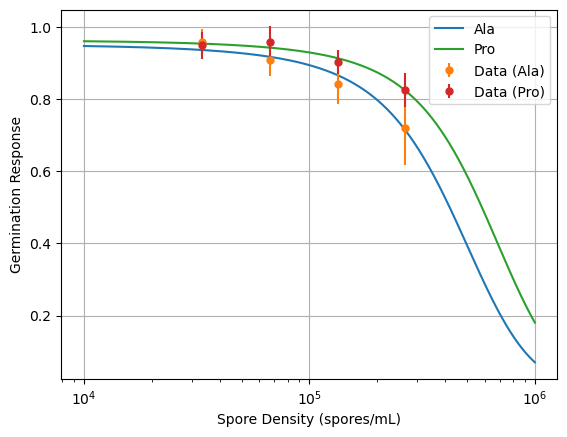

In [41]:
# Constants
μ_ξ = 2.65
σ_ξ = 0.3

# Bounds for the parameters
lower_bounds = [2, 1e-10, 1e-12]
upper_bounds = [5, 1.0, 0.1]
bounds = [(lb, ub) for (lb, ub) in zip(lower_bounds, upper_bounds)]

fig, ax = plt.subplots()

carbon_srcs = unique(df_germination_rebuilt[!, :CarbonSource])
p_opt = zeros(length(carbon_srcs), 3)
spore_densities_all = []
sample_density_exp = LinRange(4, 6, 1000)
sample_time = 24 * 3600 # 24 hours in seconds
sample_inputs = [(sample_density_exp[i], sample_time) for i in 1:length(sample_density_exp)]
for (i, src) in enumerate(carbon_srcs)

    # Skip "Arg" carbon source
    if src == "Arg"
        continue
    end

    # Gather data
    println("Carbon source: ", src)
    df_src = filter(row -> row[:CarbonSource] == src, df_germination_rebuilt)
    spore_densities = df_src[!, :Density]
    spore_density_exponents = log10.(spore_densities)
    half_saturation_times = df_src[!, :tau] * 3600 # Convert to seconds
    germination_responses = df_src[!, :Pmax] * 0.01

    inputs = collect(zip(spore_density_exponents, half_saturation_times))

    # confidence_intervals
    err_lo = df_src[!, :Pmax]-df_src[!, :Pmax_CI_Lower]
    err_lo[err_lo .< 0] .= 0
    err_hi = df_src[!, :Pmax_CI_Upper]-df_src[!, :Pmax]
    err_lo = err_lo * 0.01
    err_hi = err_hi * 0.01

    push!(spore_densities_all, spore_densities)

    # Define a scalar objective: sum of squared errors
    function obj(params)
        # ŷ = germination_response_simple.(10 .^ spore_density_exponents, 10 ^ (-params[1]), params[2], params[3], μ_ξ, σ_ξ, half_saturation_times)
        ŷ₁ = germination_response_simple.(10 .^ spore_density_exponents, 10 ^ (-params[1]), params[2], params[3], μ_ξ, σ_ξ, half_saturation_times .* 2)
        ŷ₂ = germination_response_equilibrium.(10 .^ spore_density_exponents, params[2], params[3], μ_ξ, σ_ξ)
        # return sum(abs2, ŷ .- (0.6 .* germination_responses)) # half-saturation
        # return sum(abs2, ŷ .- germination_responses) # full saturation
        return sum(abs2, ŷ₁ .- (1.0 .* germination_responses)) + sum(abs2, ŷ₂ .- germination_responses) # half saturation + equilibrium
    end

    # Fit model
    res = bboptimize(params -> obj(params);
                 SearchRange = bounds,
                 NumDimensions = 3,
                 MaxSteps = 10000)
    p_opt[i, :] = best_candidate(res)

    Pₛ_fit = 10 .^ (-p_opt[i, 1])
    μ_γ_fit = p_opt[i, 2]
    σ_γ_fit = p_opt[i, 3]

    println("Optimized parameters:")
    println("Pₛ: ", Pₛ_fit)
    println("μ_γ: ", μ_γ_fit)
    println("σ_γ: ", σ_γ_fit)
    println("")

    # fit_responses = [wrapper(input, p_opt[i, :]) for input in sample_inputs]
    fit_responses = [germination_response_simple(10 .^ input[1], 10 .^ (-p_opt[i, 1]), p_opt[i, 2], p_opt[i, 3], μ_ξ, σ_ξ, input[2]) for input in sample_inputs]
    ax.plot(10 .^ sample_density_exp, fit_responses, label=src)
    ax.errorbar(spore_densities, germination_responses, yerr=[err_lo, err_hi], fmt="o", markersize=5, label="Data ($(src))")
end

ax.set_xscale("log")
ax.set_xlabel("Spore Density (spores/mL)")
ax.set_ylabel("Germination Response")
ax.grid()
ax.legend()

gcf()

## 2. Cell wall adsorption model

If the inhibitor molecules strongly interact with the cell wall, e.g. with the hydrophobin or polysaccharide networks, their effective permeation incorporates the release deceleration due to temporary retainment in an adsorption matrix. The adsorption process can be described as a reaction between an inhibitor $\textrm{I}$ and a binding site $\textrm{S}$ to a bound complex $\textrm{IS}$:

$$
\begin{equation}
    \textrm{I}\ +\ \textrm{S}\ \leftrightarrows\ \textrm{IS}.
\end{equation}
$$

The reaction kinetics are governed by the reaction constants $k_{\textrm{on}}$ and $k_{\textrm{off}}$. Separating the concentration of inhibitor in the cell wall into a concentration of bound and of unbound inhibitor ($q$ and $c_{\textrm{free}}$, respectively), the concentration of available (unbound) sites is $B_\textrm{max}-q$, where $B_\textrm{max}$ is the maximum binding capacity in mol of binding sites per unit volume. The rate equation for $q$ is then

$$
\begin{equation}
    \frac{\partial{q}}{\partial{t}}=k_{\textrm{on}}\, c_{\textrm{free}}\, (B_\textrm{max}-q)-k_{\textrm{off}}\, q.
\end{equation}
$$

Assuming that the binding and unbinding equilibrate quickly compared to the cell wall permeation, the steady-state ($\frac{\partial{q}}{\partial{t}}\approx 0$) is given by

$$
\begin{equation}
    k_{\textrm{on}}\, c_{\textrm{free}}\, (B_\textrm{max}-q_{\textrm{eq}})=k_{\textrm{off}}\, q_{\textrm{eq}}.
\end{equation}
$$

The solution for this equation is the Langmuir isotherm

$$
\begin{equation}
    q_{\textrm{eq}}=\frac{B_\textrm{max}\,K_{\textrm{eq}}\,c_{\textrm{free}}}{1+K_{\textrm{eq}}\,c_{\textrm{free}}},
\end{equation}
$$

where $K_{\textrm{eq}}=\frac{k_{\textrm{on}}}{k_{\textrm{off}}}$ is an equilibrium constant. As long as $K_{\textrm{eq}}\,c_{\textrm{free}}\ll 1$, i.e. the binding affinity is not strong enough to cause saturation of bound sites, the linear approximation

$$
\begin{equation}
    q_{\textrm{eq}}\approx B_\textrm{max}\,K_{\textrm{eq}}\,c_{\textrm{free}}
\end{equation}
$$

can be made. Thus, following the mass conservation law, the inhibitor diffusion in the cell wall follows the dynamics

$$
\begin{equation}
    \frac{\partial{c_{\textrm{cw}}}}{\partial{t}}= \frac{\partial}{\partial{t}}(q+c_{\textrm{free}})=D\frac{\partial^2{c_{\textrm{free}}}}{\partial{t}^2},
\end{equation}
$$

where only $c_{\textrm{free}}$ diffuses freely according to Fick's law. Thus,

$$
\begin{equation}
    (1+B_\textrm{max}\,K_{\textrm{eq}})\,\frac{\partial{c_{\textrm{free}}}}{\partial{t}}=D\frac{\partial^2{c_{\textrm{free}}}}{\partial{t}^2},
\end{equation}
$$

$$
\begin{equation}
    \frac{\partial{c_{\textrm{free}}}}{\partial{t}}=\frac{D}{1+B_\textrm{max}\,K_{\textrm{eq}}}\,\frac{\partial^2{c_{\textrm{free}}}}{\partial{t}^2}.
\end{equation}
$$

It becomes evident that the diffusion constant is replaced by an effective diffusivity modulated by adsorption:

$$
\begin{equation}
    D_{\textrm{eff}}=\frac{D}{1+B_\textrm{max}\,K_{\textrm{eq}}}.
\end{equation}
$$

In the general permeation case, this can be translated to an effective permeation constant:

$$
\begin{equation}
    P_{\textrm{eff}}=\frac{D_{\textrm{eff}}}{d}=\frac{1}{d}\frac{D}{1+K_{\textrm{eq}}\,B_{\textrm{max}}},
\end{equation}
$$

$$
\begin{equation}
    P_{\textrm{eff}}=\frac{P_s}{1+K_{\textrm{eq}}\,B_{\textrm{max}}}.
\end{equation}
$$

Also, using the Meyer-Overton rule,

$$
\begin{equation}
    P_{\textrm{eff}}=\frac{KD_{\textrm{eff}}}{d}=\frac{K}{d}\frac{D}{1+K_{\textrm{eq}}\,B_{\textrm{max}}},
\end{equation}
$$

$$
\begin{equation}
    P_{\textrm{eff}}=\frac{P_s}{1+K_{\textrm{eq}}\,B_{\textrm{max}}}.
\end{equation}
$$

This justifies the use of a wider range of material-characteristic permeation constants while quantifying the potential adsorption dynamics in the cell wall. It can thus be tested if, given a specific permeation value (e.g. the lowest permeation coefficient from Notebook 12), the experimental data can be approximated without violating the assumption of a linear regime ($K_{\textrm{eq}}\,c_{\textrm{free}}\ll 1$).

In [ ]:
# Constants
μ_ξ = 2.65
σ_ξ = 0.3
Pₛ = cm_to_um(2.474273528258106e-5)

# Initial guesses and bounds for the parameters
lower_bounds = [1e-10, 1e-12, 1.0]
upper_bounds = [1.0, 0.1, 1e9]
bounds = [(lb, ub) for (lb, ub) in zip(lower_bounds, upper_bounds)]

fig, ax = plt.subplots()

carbon_srcs = unique(df_germination_rebuilt[!, :CarbonSource])
p_opt = zeros(length(carbon_srcs), 3)
spore_densities_all = []
sample_density_exp = LinRange(4, 6, 1000)
sample_time = 72 * 3600 # 72 hours in seconds
sample_inputs = [(sample_density_exp[i], sample_time) for i in 1:length(sample_density_exp)]
for (i, src) in enumerate(carbon_srcs)

    # Skip "Arg" carbon source
    if src == "Arg"
        continue
    end

    # Gather data
    println("Carbon source: ", src)
    df_src = filter(row -> row[:CarbonSource] == src, df_germination_rebuilt)
    spore_densities = df_src[!, :Density]
    spore_density_exponents = log10.(spore_densities)
    half_saturation_times = df_src[!, :tau] * 3600 # Convert to seconds
    germination_responses = df_src[!, :Pmax] * 0.01

    inputs = zip(spore_density_exponents, half_saturation_times)

    # confidence_intervals
    err_lo = df_src[!, :Pmax]-df_src[!, :Pmax_CI_Lower]
    err_lo[err_lo .< 0] .= 0
    err_hi = df_src[!, :Pmax_CI_Upper]-df_src[!, :Pmax]
    err_lo = err_lo * 0.01
    err_hi = err_hi * 0.01

    push!(spore_densities_all, spore_densities)

    # Define a scalar objective: sum of squared errors
    function obj(params)
        ŷ = germination_response_simple.(10 .^ spore_density_exponents, Pₛ / (1 + params[3]), params[1], params[2], μ_ξ, σ_ξ, half_saturation_times)
        return sum(abs2, ŷ .- (0.5 .* germination_responses)) # half-saturation
    end

    # Fit model
    res = bboptimize(params -> obj(params);
                 SearchRange = bounds,
                 NumDimensions = 3,
                 MaxSteps = 10000)
    p_opt[i, :] = best_candidate(res)

    Pₛ_fit = 10 .^ (-p_opt[i, 1])
    μ_γ_fit = p_opt[i, 2]
    σ_γ_fit = p_opt[i, 3]

    println("Optimized parameters:")
    println("K_eq * B_max: ", Pₛ_fit)
    println("μ_γ: ", μ_γ_fit)
    println("σ_γ: ", σ_γ_fit)
    println("")

    fit_responses = [wrapper(input, p_opt[i, :]) for input in sample_inputs]
    ax.plot(10 .^ sample_density_exp, fit_responses, label=src)
    ax.errorbar(spore_densities, germination_responses, yerr=[err_lo, err_hi], fmt="o", markersize=5, label="Data ($(src))")
end

ax.set_xscale("log")
ax.set_xlabel("Spore Density (spores/mL)")
ax.set_ylabel("Germination Response")
ax.grid()
ax.legend()

gcf()

## 3. Inducer-inhibitor interaction

As conidial germination is influenced not only by auto-inhibition but also by inducing carbon signals in the medium, the question arises how these two mechanisms interact to enable the break of dormancy.

### 3.1. Independent induction and inhibition

In the simplest scenario, the two mechanisms can be viewed as mutually independent, causing germination when both conditions,

$$
\begin{equation}
c_{\textrm{in}}<c_T^-\quad\textrm{and}\quad sc_{\textrm{cs}}>c_T^+,
\end{equation}
$$

are fulfilled simultaneously. Here, $c_{\textrm{in}}$ is the residual inhibitor concentration in the spore, $c_{\textrm{cs}}$ is the carbon source concentration around the carbon sensing proteins, $s$ quantifies the inducing strength of the carbon source and $c_T^-$ and $c_T^+$ are the concentration thresholds for the inhibitory and the inducing signals, respectively.

Similar to the inhibition threshold, the induction threshold $c_T^+$ can be modelled by a normally distributed random variable $\omega$, with mean $\mu_\omega$ and standard deviation $\sigma_\omega$. The germination probability can therefore be expressed as

$$
\begin{equation}
p=P{\left(\beta<\gamma\ \cap\ \omega < sc_{\textrm{cs}}\right)}=P{(\beta<\gamma)}\cdot P{(\omega < sc_{\textrm{cs}})}.
\end{equation}
$$

The first probability follows the familiar formula

$$
\begin{equation}
P{(\beta<\gamma)}=\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ \frac{1}{\sqrt{2\pi}\sigma_\xi}\exp{\left(-\frac{(\xi-\mu_\xi)^2}{2\sigma_\xi^2}\right)}\ d{\xi}}.
\end{equation}
$$

The second probability simply incorporates a Gaussian CDF:

$$
\begin{equation}
P{(\omega < sc_{\textrm{cs}})}=\Phi{\left(\frac{sc_{\textrm{cs}}-\mu_\omega}{\sigma_\omega}\right)}.
\end{equation}
$$

Hence,

$$
\begin{equation}
P{\left(\beta<\gamma\ \cap\ \omega < sc_{\textrm{cs}}\right)}=\Phi{\left(\frac{sc_{\textrm{cs}}-\mu_\omega}{\sigma_\omega}\right)}\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ \frac{1}{\sqrt{2\pi}\sigma_\xi}\exp{\left(-\frac{(\xi-\mu_\xi)^2}{2\sigma_\xi^2}\right)}\ d{\xi}}.
\end{equation}
$$

This expression introduces three new unknown variables: $s$, $\mu_\omega$ and $\sigma_\omega$. It is assumed that the inducer threshold is universal for all types of carbon sources, but the induction index $s$ describes the specific signalling efficacy of different nutrients. Therefore, it is interesting to investigate whether fitting the model over experimental data produces consistent values for $\mu_\omega$ and $\sigma_\omega$, with varying $s$ for different carbon sources.

### 3.2. Inducer-mediated inhibition threshold

A second possibility is that the carbon signals, readily available in the medium, quickly diffuse into the cell wall, reaching the receptor proteins and triggering, as a consequence of the cAMP-PKA pathway, a lifting of the inhibition threshold, making a break of dormancy mediated by inhibitor depletion easier to reach.

Previously, it was observed that the variation in germination response under varying inducing media is explainable by a modulation of the inhibitor concentration threshold and not so much by a change in permeability.

### 3.3. Inhibitor-mediated carbon sensitivity

Another possibility is that the inhibitor acts upon the carbon signalling pathway. Therefore, once the inhibition is removed, the cAMP-PKA pathway may receive stronger triggers that can switch the germination regime on.

### 3.4. Feedback loop

Finally,

## 4. Inducer permeation model

## References

- [1] Dantigny, P., Nanguy, S.P., Judet-Correia, D., & Bensoussan, M. (2011). A new model for germination of fungi. International journal of food microbiology, 146 2, 176-81 .
- [2] Ijadpanahsaravi, Maryam, L. Basten Snoek, Wieke R. Teertstra and Han A. B. Wösten. “The impact of inter- and intra-species spore density on germination of the food spoilage fungus Aspergillus niger.” _International journal of food microbiology_ 410 (2023): 110495 .